In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from typing import NamedTuple

In [2]:
class TrainData(NamedTuple):
    train_images: np.ndarray
    train_labels: np.ndarray

class TestData(NamedTuple):
    test_images: np.ndarray
    test_labels: np.ndarray

class DataSet(NamedTuple):
    TrainData: TrainData
    TestData: TestData


def get_2_class_raw_dataset(class_names: list[str]=[3, 5]) -> DataSet:
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    
    train_mask = np.isin(train_labels, class_names).reshape(-1)
    train_images = train_images[train_mask]
    train_labels = train_labels[train_mask]

    test_mask = np.isin(test_labels, class_names).reshape(-1)
    test_images = test_images[test_mask]
    test_labels = test_labels[test_mask]

    train_labels = np.where(train_labels == 3, 0, 1)
    test_labels = np.where(test_labels == 3, 0, 1)

    return (train_images, train_labels), (test_images, test_labels)

In [3]:
def _process_x(x):
    img = tf.cast(x, tf.float32) / 255
    return img

def _process_y(y):
    y = tf.one_hot(tf.squeeze(y), 2)
   
    return y

def get_train_dataset():
    (train_images, train_labels), (_, _) = get_2_class_raw_dataset()

    x_dataset = tf.data.Dataset.from_tensor_slices(train_images)
    y_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
    
    x_dataset = x_dataset.map(_process_x)
    y_dataset = y_dataset.map(_process_y)

    dataset = tf.data.Dataset.zip((x_dataset, y_dataset))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(4)
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset

def check_train_dataset() -> None:
    dataset = get_train_dataset()
    
    for x, y in dataset.take(1):
        print("Shape of x:", x.shape, "Shape of y:", y.shape)  # должно быть что-то вроде (4, 32, 32, 3) и (4, 2)
    
check_train_dataset()

Shape of x: (4, 32, 32, 3) Shape of y: (4, 2)


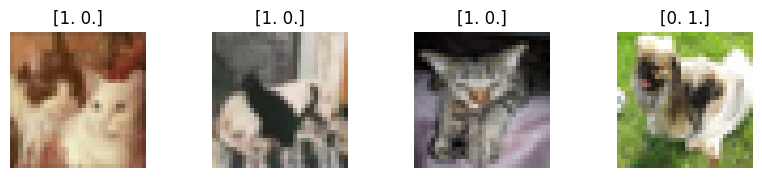

In [12]:
def show_dataset(plot_number: int=4) -> None:
    dataset = get_train_dataset()
    
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(plot_number):
            img = images[i]
            label = labels[i]
            ax = plt.subplot(3, plot_number, i + 1 + plot_number)
            plt.imshow(img)
            plt.title(str(labels.numpy()[i]))
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
            
        plt.show()
show_dataset()

In [13]:
def get_model_layers():
    inputs = Input(shape=(32, 32, 3))
    x = inputs
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)
    outputs = x
    cnn = keras.Model(inputs, outputs)
    return cnn
    
get_model_layers().summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303,778 (1.16 MB)

 Trainable params: 303,778 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        self.optimizer = tf.keras.optimizers.Adam()

    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(y, preds)
        return loss

    @tf.function
    def training_step(self, x, y):
        with tf.GradientTape() as tape:
            preds = self.nn(x)
            loss = self.get_loss(y, preds)

        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)

In [15]:
def compile_model():
    cnn = get_model_layers()
    model = Model(cnn)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    return model

compile_model()

<Model name=model_3, built=False>

In [16]:
def check_teaching_model(): 
    dataset = get_train_dataset()
    model = compile_model()
    
    for x, y in dataset.take(1):
        print(model.training_step(x, y))

check_teaching_model()

tf.Tensor(0.6911775, shape=(), dtype=float32)


20


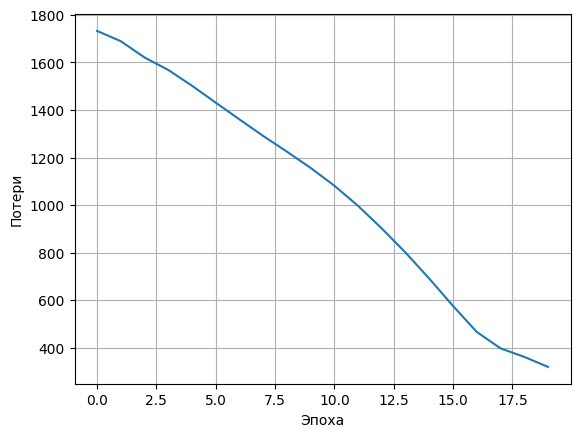

In [17]:
def teach_model(epochs: int):
    hist = np.array(np.empty([0]))
    dataset = get_train_dataset()
    model = compile_model()
    
    for epoch in range(1, epochs + 1):
        loss = 0
        for step, (x, y) in enumerate(dataset):
            loss += model.training_step(x, y)
        clear_output(wait=True)
        print(epoch)
        hist = np.append(hist, loss)
        plt.plot(np.arange(0, len(hist)), hist)
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.grid(True)
        plt.show()


teach_model(20)       

In [24]:
def get_model(epochs=20):
    dataset = get_train_dataset()
    model = compile_model()
    
    for epoch in range(1, epochs + 1):
        loss = 0
        for step, (x, y) in enumerate(dataset):
            loss += model.training_step(x, y)
    return model

In [25]:
model = get_model()

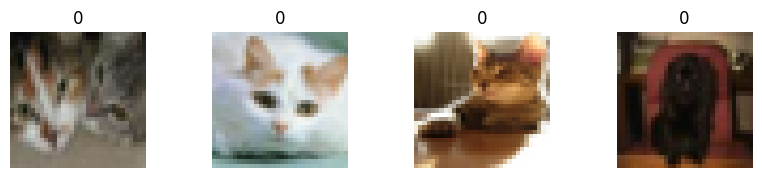

In [30]:
def pred_dataset(n: int=4):
            
    plt.figure(figsize=(10, 6))
    dataset = get_train_dataset()
    
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            img_tensor = tf.expand_dims(img, axis=0)
            pred = model.nn(img_tensor)
            pred = tf.squeeze(pred, axis=0)
            pred = pred.numpy()

            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img)

            ma = pred.max()
            res = np.where(pred == ma)

            plt.title(res[0][0])
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
        plt.show()

pred_dataset()